<a href="https://colab.research.google.com/github/Keara9/EmotionRecognition/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torchvision.transforms as transforms
from torchvision.transforms import Normalize
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
import os
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


In [ ]:


df = pd.read_csv('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge (1)/icml_face_data.csv')

df.head()
print(df.columns)



Index(['emotion', ' Usage', ' pixels'], dtype='object')


In [ ]:

df = df.rename(columns = {" pixels": "pixels", " Usage": "usage"})

emotion_labels = {0:'Angry',1:'Disgust',2:'Fear',3:'Happy',4:'Sad',5:'Surprise',6:'Neutral'}
print(df.columns)

Index(['emotion', 'usage', 'pixels'], dtype='object')


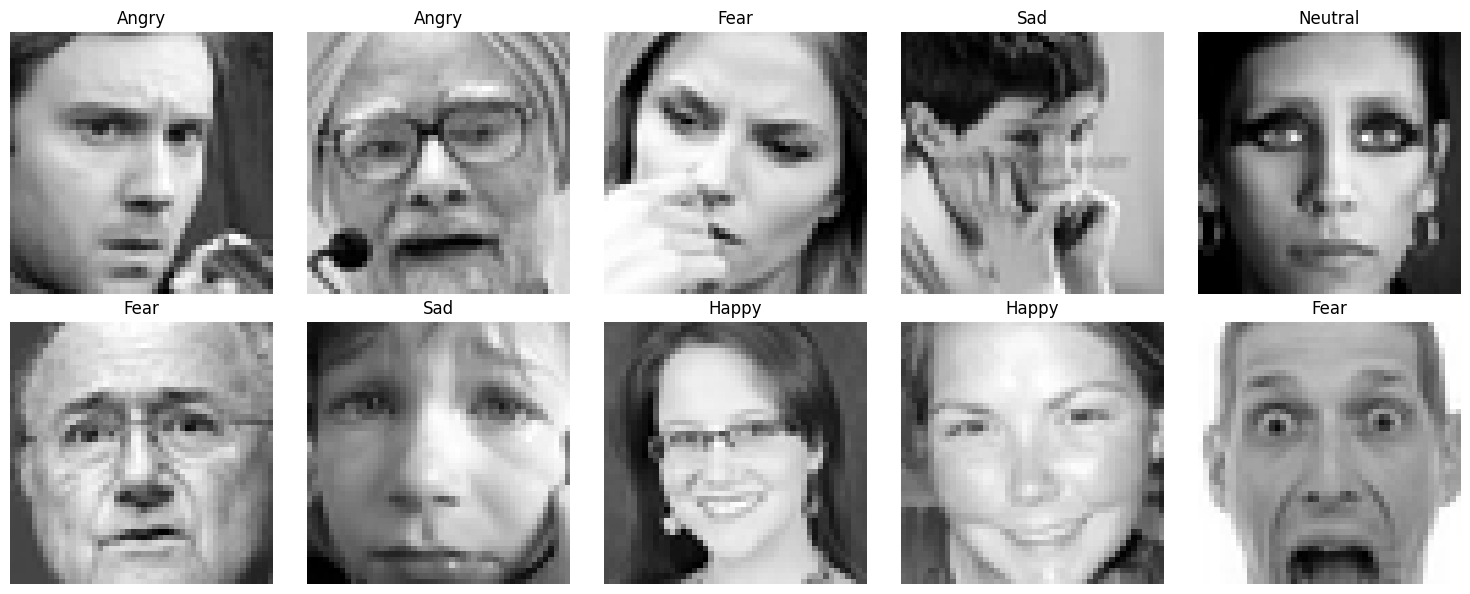

In [ ]:

# Show sample images
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i, ax in enumerate(axes.flatten()):
    pixels = np.array(df['pixels'][i].split(), dtype='float32').reshape(48, 48)
    ax.imshow(pixels, cmap='gray')
    ax.set_title(emotion_labels[df["emotion"][i]])
    ax.axis('off')
plt.tight_layout()
plt.show()


In [ ]:

# Show the class distribtuion
class Distribution:
    def __init__(self, data):
        self.data = data.reset_index(drop=True)
        self.emotion_labels = {
            0: 'Angry', 1: 'Disgust', 2: 'Fear',
            3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'
        }

    def plot_distribution(self):
        emotion_counts = self.data['emotion'].value_counts().sort_index()
        labels = [self.emotion_labels[i] for i in emotion_counts.index]

        plt.figure(figsize=(10, 6))
        plt.bar(labels, emotion_counts.values, color='magenta')
        plt.xlabel("Emotions")
        plt.ylabel("Number of Images")
        plt.title("Class Distribution")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    def plot_sample_images(self, n=5):
        plt.figure(figsize=(n * 2, 2.5))
        for i in range(min(n, len(self.data))):
            row = self.data.iloc[i]
            try:
                pixels = np.array(row['pixels'].split(), dtype='float32').reshape(48, 48)
            except Exception as e:
                print(f"Error processing image {i}: {e}")
                continue

            plt.subplot(1, n, i + 1)
            plt.imshow(pixels, cmap='gray')
            plt.title(self.emotion_map[row['emotion']])
            plt.axis('off')

        plt.tight_layout()
        plt.show()



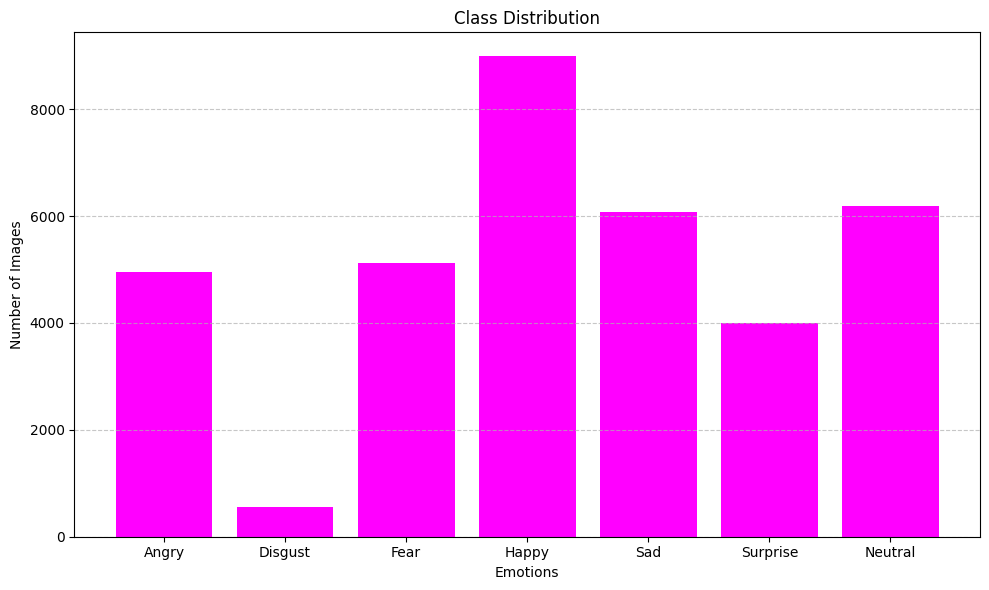

In [ ]:
distribution = Distribution(df)
distribution.plot_distribution()

In [ ]:
class FERDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        pixels = np.array([int(p) for p in row[' pixels'].split()], dtype='uint8').reshape(48, 48)
        image = Image.fromarray(pixels)
        label = int(row['emotion'])

        if self.transform:
            image = self.transform(image)

        return image, label

In [ ]:
# Normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])


In [ ]:
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [ ]:
def load_dataset(csv_path, train_transform, test_transform):

    # Load the DataFrame
    df = pd.read_csv(csv_path)

    # Use only training set to split into train/val
    train_val_df = df[df[' Usage'] == 'Training']
    test_df = df[df[' Usage'] == 'PrivateTest']

    train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['emotion'])
    train_dataset = FERDataset(train_df, transform=train_transform)
    val_dataset = FERDataset(val_df, transform=test_transform)
    test_dataset = FERDataset(test_df, transform=test_transform)

    return train_dataset, val_dataset, test_dataset
# Set device
device = 'cuda'

# Load data
transform = transforms.Compose([
    transforms.ToTensor(),
])
train_dataset, val_dataset, test_dataset = load_dataset('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge (1)/icml_face_data.csv', transform, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define model and optimizer, criterion and run the training loop as before

In [ ]:

# Device setup
device = 'cuda'

def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, labels) in enumerate(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    return epoch_loss


In [ ]:


class EmotionRecognitionCNN(nn.Module):
    def __init__(self, num_classes):
        super(EmotionRecognitionCNN, self).__init__()
        self.num_classes = num_classes

        # Convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.residual = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.dropout = nn.Dropout(0.5)


        self.flattened_size = 64 * 12 * 12

        # Fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, self.num_classes)

        # Initialize weights
        self._initialize_weights()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        residual = x
        x = self.residual(x)
        x = x  + residual
        x = x.view(x.size(0), -1)
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [ ]:


# Initialize model
model = EmotionRecognitionCNN(num_classes=7).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load data
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset, val_dataset, test_dataset = load_dataset('/content/drive/MyDrive/challenges-in-representation-learning-facial-expression-recognition-challenge (1)/icml_face_data.csv', transform, transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):

        train_loss = train(model, train_loader, criterion, optimizer, device)
        test_loss, accuracy = evaluate(model, test_loader, criterion)
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, "
              f"Test Loss: {test_loss:.4f}, "
              f"Accuracy: {accuracy:.4f}")


Epoch [1/10], Train Loss: 1.7550, Test Loss: 1.5882, Accuracy: 0.3842
Epoch [2/10], Train Loss: 1.6195, Test Loss: 1.5719, Accuracy: 0.3870
Epoch [3/10], Train Loss: 1.5583, Test Loss: 1.4627, Accuracy: 0.4126
Epoch [4/10], Train Loss: 1.5153, Test Loss: 1.4183, Accuracy: 0.4578
Epoch [5/10], Train Loss: 1.4806, Test Loss: 1.4598, Accuracy: 0.4436
Epoch [6/10], Train Loss: 1.4407, Test Loss: 1.3873, Accuracy: 0.4745
Epoch [7/10], Train Loss: 1.4243, Test Loss: 1.3277, Accuracy: 0.4987
Epoch [8/10], Train Loss: 1.3921, Test Loss: 1.3202, Accuracy: 0.5065
Epoch [9/10], Train Loss: 1.3708, Test Loss: 1.3312, Accuracy: 0.4971
Epoch [10/10], Train Loss: 1.3403, Test Loss: 1.3052, Accuracy: 0.5135


In [ ]:
import plotly.graph_objects as go

def plot_training(train_losses, val_losses, train_accs, val_accs):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=train_losses, name='Train Loss'))
    fig.add_trace(go.Scatter(y=val_losses, name='Val Loss'))
    fig.add_trace(go.Scatter(y=train_accs, name='Train Accuracy'))
    fig.add_trace(go.Scatter(y=val_accs, name='Val Accuracy'))
    fig.update_layout(title='Training and Validation Metrics', xaxis_title='Epoch', yaxis_title='Metric')
    fig.show()

# Main training loop
num_epochs = 10
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss = train(model=model, dataloader=train_loader, optimizer=optimizer, criterion=criterion, device=device)
    train_loss, train_acc = evaluate(model, train_loader, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

# Plot training results
plot_training(train_losses, val_losses, train_accs, val_accs)


Epoch 1/10, Train Loss: 1.1960, Val Loss: 1.3019, Train Acc: 0.5540, Val Acc: 0.5016
Epoch 2/10, Train Loss: 1.1157, Val Loss: 1.2598, Train Acc: 0.5868, Val Acc: 0.5174
Epoch 3/10, Train Loss: 1.1363, Val Loss: 1.2827, Train Acc: 0.5867, Val Acc: 0.5068
Epoch 4/10, Train Loss: 1.1169, Val Loss: 1.2759, Train Acc: 0.5964, Val Acc: 0.5075
Epoch 5/10, Train Loss: 0.9989, Val Loss: 1.2301, Train Acc: 0.6315, Val Acc: 0.5268
Epoch 6/10, Train Loss: 0.9911, Val Loss: 1.2387, Train Acc: 0.6484, Val Acc: 0.5265
Epoch 7/10, Train Loss: 0.9590, Val Loss: 1.2574, Train Acc: 0.6520, Val Acc: 0.5317
Epoch 8/10, Train Loss: 0.9090, Val Loss: 1.2533, Train Acc: 0.6700, Val Acc: 0.5390
Epoch 9/10, Train Loss: 0.9098, Val Loss: 1.2674, Train Acc: 0.6754, Val Acc: 0.5326
Epoch 10/10, Train Loss: 0.9144, Val Loss: 1.2651, Train Acc: 0.6755, Val Acc: 0.5273


In [ ]:
# Helper function to visualize Grad-CAM on a test image
def visualize_gradcam(model, image_tensor, label, class_names):
    model.eval()
    # Use the last convolutional layer for Grad-CAM
    target_layer = model.residual[0]

    cam = GradCAM(model=model, target_layers=[target_layer])

    # Prepare input image for Grad-CAM
    input_tensor = image_tensor.unsqueeze(0).to(device)
    targets = [ClassifierOutputTarget(label)]

    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    input_image = image_tensor.squeeze().cpu().numpy()
    input_image = (input_image * 0.5 + 0.5)
    input_image_rgb = np.stack([input_image]*3, axis=-1)
    visualization = show_cam_on_image(input_image_rgb, grayscale_cam, use_rgb=True)

    plt.imshow(visualization)
    plt.title(f"Grad-CAM for class: {class_names[label]}")
    plt.axis('off')
    plt.show()

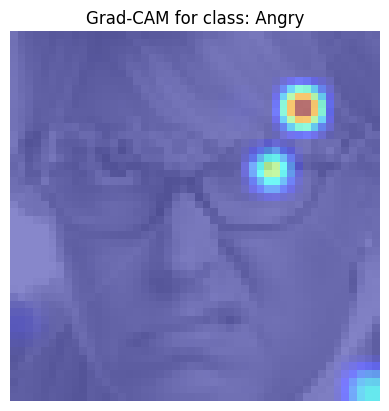

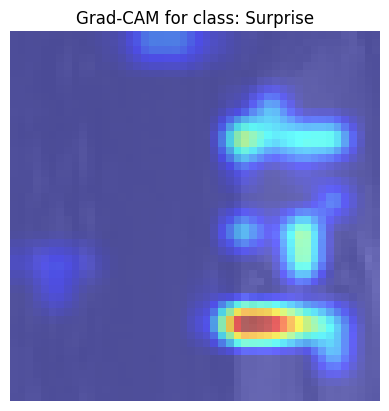

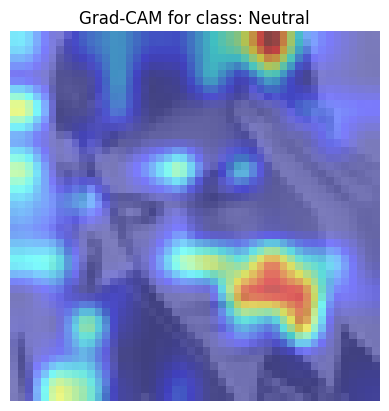

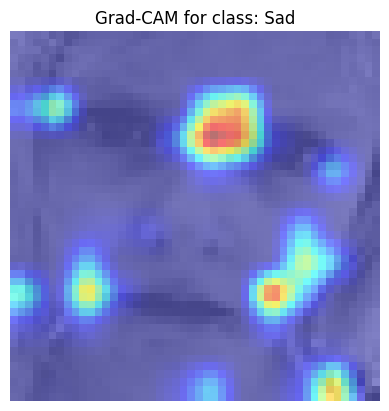

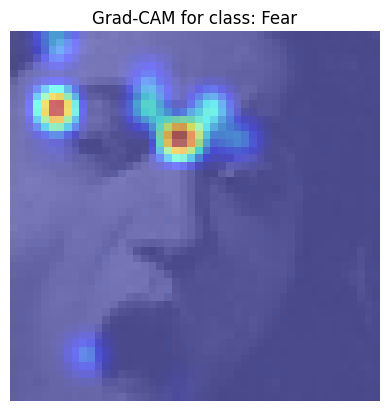

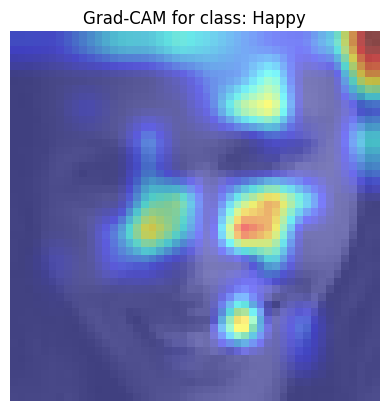

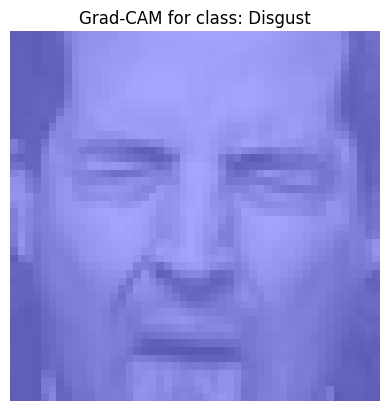

In [ ]:
from collections import defaultdict
import torch

examples_by_emotion = defaultdict(lambda: None)

# Search test dataset for one image per emotion
for image_tensor, label in test_dataset:
    label_idx = int(label)
    if examples_by_emotion[label_idx] is None:
        examples_by_emotion[label_idx] = image_tensor
    if len(examples_by_emotion) == len(emotion_labels):
        break

# Visualize one example for each emotion
for label_idx, image_tensor in examples_by_emotion.items():
    visualize_gradcam(model, image_tensor, label_idx, emotion_labels)